In [33]:
import torch
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.decomposition import PCA
import numpy as np 
from __future__ import absolute_import, division, print_function
import pyro
from pyro.contrib.gp.util import Parameterized
import pyro.distributions as dist
import pyro.infer as infer
import pyro.optim as optim
from pyro.params import param_with_module_name
import pyro.contrib.gp as gp
import pyro.distributions as dist
import matplotlib.pyplot as plt
pyro.clear_param_store()
import tensorflow as tf
import numpy as np 
import pandas as pd
import numpy
import math
import cProfile
import time
import GPy
import numpy as np
from matplotlib import pyplot as plt

#import statsmodels.api as sm
#import sympy as sp
#import pymc
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
from scipy.special import gamma
from GPy.core.parameterization.variational import NormalPosterior, NormalPrior

#from sympy.interactive import printing
import pyro.contrib.gp.models.vsgp as vsgp
from GPy.util.linalg import pdinv
from pyro.infer.mcmc.hmc import HMC
from pyro.infer.mcmc import MCMC
from matplotlib import pyplot
pyro.clear_param_store()
import time
torch.manual_seed(12)
pyro.set_rng_seed(101)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.decomposition import PCA
import numpy as np 
import gpflow

In [34]:
import pandas as pd

In [35]:
data = pd.read_csv('LSVT_voice_rehabilitation.csv')

In [36]:
label= data['OQ->prc5_95']

In [37]:
data = data.drop(['OQ->prc5_95'],axis=1)

In [38]:
X = np.array(data)

In [39]:
def initialize_latent(input_dim, Y):
    Xr = np.asfortranarray(np.random.normal(0, 1, (Y.shape[0], input_dim)))
    p = GPy.util.pca.PCA(Y)
    PC = p.project(Y, min(input_dim, Y.shape[1]))
    Xr[:PC.shape[0], :PC.shape[1]] = PC
    var = .1*p.fracs[:input_dim]
    Xr -= Xr.mean(0)
    Xr /= Xr.std(0)
    return Xr, var/var.max()

In [40]:
N = X.shape[0]
sample_mean = np.mean(X[:N,:])
sample_std = np.std(X[:N,:])
sample_norm = (X[:N,:] - sample_mean)/sample_std # normalisation
X_flat = np.array(sample_norm)

In [51]:
pyro.clear_param_store()
M = 20# number of inducing pts
Q=5
X_mean = gpflow.models.PCA_reduce(X_flat, Q) # Initialise via PCA
Z = np.random.permutation(X_mean.copy())[:M]
Xu = torch.tensor(Z).float()
Xr, fracs = initialize_latent(Q, X_flat)
X_loc = torch.tensor(Xr).float()
fracs = torch.tensor(1./fracs).float()
kernel = gp.kernels.RBF(input_dim=Q, lengthscale=fracs)
gpmodel = gp.models.SparseGPRegression(X_loc, torch.tensor(X_flat.T).float(), kernel, Xu, noise=torch.tensor(0.|5),approx='DTC')
gplvm = gp.models.GPLVM(gpmodel)

TypeError: unsupported operand type(s) for |: 'float' and 'int'

CPU+SystemTime:125.90625 seconds
Code Run Time:86.9328727722168 seconds


Text(0.5,1,'Convergence of SVI')

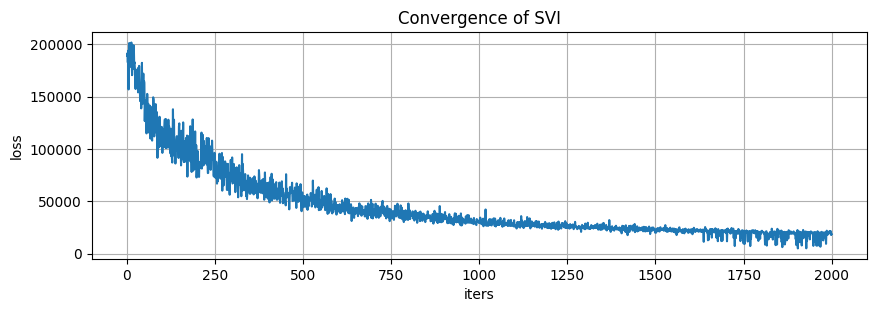

In [52]:
i=list(range(1,2001))
st = time.process_time()
st2 = time.time()
losses = gplvm.optimize(num_steps=2000)  # doctest: +SKIP
end =  time.process_time()
end2 = time.time()
print(str('CPU+SystemTime:')+str(end-st)+' '+str('seconds'))
print(str('Code Run Time:')+str(end2-st2)+' '+str('seconds'))
pyplot.figure(figsize=(10,3), dpi=100).set_facecolor('white')
pyplot.plot(i,losses)
pyplot.xlabel('iters')
pyplot.ylabel('loss')
pyplot.grid()
pyplot.title('Convergence of SVI')

In [53]:
dd_orig = distance_matrix(X_flat)
dd_proj = distance_matrix(gplvm.get_param('X_loc').detach().numpy())
nn_orig = dd_orig.argsort()
nn_proj = dd_proj.argsort()
ranks_proj = rank_matrix(dd_proj)
ks=[1,3,5,7,10,15]
j=0
cont=[]
for k in ks:
    moved = []
    for i in range(X.shape[0]):
        moved.append(moved_out(nn_orig, nn_proj, i, k))
    cont.append(trustcont_sum(moved, ranks_proj, k))
    print('Neearest neighbourboost size k =' + str(k)+ ' ' + 'Continuity:' + str(cont[j]))
    j+=1

Neearest neighbourboost size k =1 Continuity:0.8067716333845366
Neearest neighbourboost size k =3 Continuity:0.8262057807512353
Neearest neighbourboost size k =5 Continuity:0.8162631154156578
Neearest neighbourboost size k =7 Continuity:0.8195602878832693
Neearest neighbourboost size k =10 Continuity:0.8157868275515334
Neearest neighbourboost size k =15 Continuity:0.8059639389736477


In [54]:
ranks_orig =rank_matrix(dd_orig)
trust = []
j=0
for k in ks:
    moved = []
    for i in range(X_flat.shape[0]):
        moved.append(moved_in(nn_orig, nn_proj, i, k))
    trust.append(trustcont_sum(moved, ranks_orig, k))
    print('Neearest neighbourboost size k =' + str(k)+ ' ' + 'Trust:' + str(trust[j]))
    j+=1

Neearest neighbourboost size k =1 Trust:0.9181387608806963
Neearest neighbourboost size k =3 Trust:0.9087192269010451
Neearest neighbourboost size k =5 Trust:0.9071428571428571
Neearest neighbourboost size k =7 Trust:0.9025337671300404
Neearest neighbourboost size k =10 Trust:0.9016663075486605
Neearest neighbourboost size k =15 Trust:0.8995274053526481


CPU+SystemTime:311.96875 seconds
Code Run Time:212.61330318450928 seconds


Text(0.5,1,'Convergence of SVI-FITC')

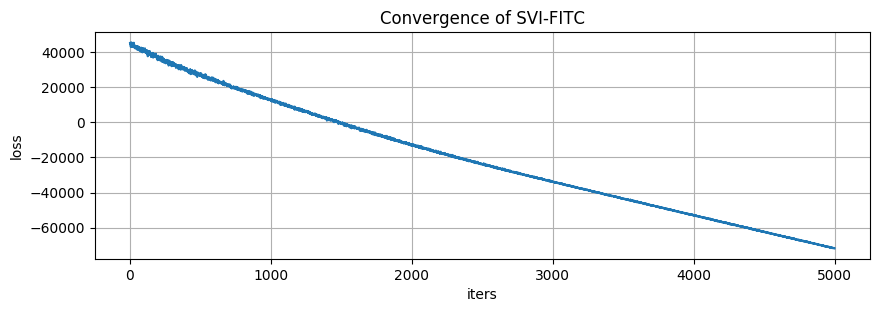

In [47]:
pyro.clear_param_store()
Y_t=torch.tensor(X_flat.T).float()
gpmodel2 = gp.models.SparseGPRegression(X_loc, Y_t, kernel, Xu, noise=torch.tensor(0.5),approx='FITC')
gplvm2 = gp.models.GPLVM(gpmodel2)

i=list((range(1,5001)))
st =  time.process_time()
st2 = time.time()
losses2 = gplvm2.optimize(num_steps=5000)  # doctest: +SKIP
end =  time.process_time()
end2 = time.time()
print(str('CPU+SystemTime:')+str(end-st)+' '+str('seconds'))
print(str('Code Run Time:')+str(end2-st2)+' '+str('seconds'))
pyplot.figure(figsize=(10,3), dpi=100).set_facecolor('white')
pyplot.plot(i,losses2)
pyplot.xlabel('iters')
pyplot.ylabel('loss')
pyplot.grid()
pyplot.title('Convergence of SVI-FITC')

In [49]:
dd_orig = distance_matrix(X_flat)
dd_proj = distance_matrix(gplvm2.get_param('X_loc').detach().numpy())
nn_orig = dd_orig.argsort()
nn_proj = dd_proj.argsort()
ranks_proj = rank_matrix(dd_proj)
j=0
cont=[]
for k in ks:
    moved = []
    for i in range(X_flat.shape[0]):
        moved.append(moved_out(nn_orig, nn_proj, i, k))
    cont.append(trustcont_sum(moved, ranks_proj, k))
    print('Neearest neighbourboost size k =' + str(k)+ ' ' + 'Continuity:' + str(cont[j]))
    j+=1

ranks_orig =rank_matrix(dd_orig)
trust = []
j=0
for k in ks:
    moved = []
    for i in range(X_flat.shape[0]):
        moved.append(moved_in(nn_orig, nn_proj, i, k))
    trust.append(trustcont_sum(moved, ranks_orig, k))
    print('Neearest neighbourboost size k =' + str(k)+ ' ' + 'Trust:' + str(trust[j]))
    j+=1

Neearest neighbourboost size k =1 Continuity:0.9308115719406042
Neearest neighbourboost size k =3 Continuity:0.948051948051948
Neearest neighbourboost size k =5 Continuity:0.9444175410277105
Neearest neighbourboost size k =7 Continuity:0.9468993394459233
Neearest neighbourboost size k =10 Continuity:0.9445162680456798
Neearest neighbourboost size k =15 Continuity:0.9383880413006627
Neearest neighbourboost size k =1 Trust:0.9599334357398873
Neearest neighbourboost size k =3 Trust:0.9615855524946434
Neearest neighbourboost size k =5 Trust:0.9627925746569814
Neearest neighbourboost size k =7 Trust:0.9619934930493936
Neearest neighbourboost size k =10 Trust:0.9641241111829347
Neearest neighbourboost size k =15 Trust:0.9693532644988956


In [55]:
pyro.clear_param_store()
gpmodel3 = gp.models.SparseGPRegression(X_loc, Y_t, kernel, Xu, noise=torch.tensor(0.5),approx='VFE')
gplvm3 = gp.models.GPLVM(gpmodel3)

CPU+SystemTime:166.453125 seconds
Code Run Time:86.87994933128357 seconds


Text(0.5,1,'Convergence of SVI-VFE')

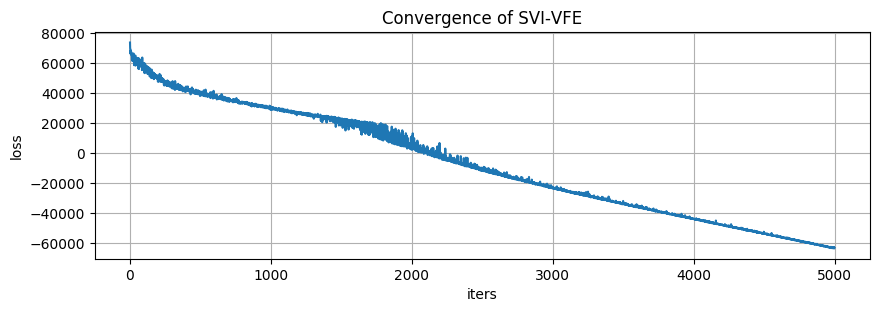

In [57]:

i=list((range(1,5001)))
st =  time.process_time()
st2 = time.time()
losses3 = gplvm3.optimize(num_steps=5000)  # doctest: +SKIP
end =  time.process_time()
end2 = time.time()
print(str('CPU+SystemTime:')+str(end-st)+' '+str('seconds'))
print(str('Code Run Time:')+str(end2-st2)+' '+str('seconds'))
pyplot.figure(figsize=(10,3), dpi=100).set_facecolor('white')
pyplot.plot(i,losses3)
pyplot.xlabel('iters')
pyplot.ylabel('loss')
pyplot.grid()
pyplot.title('Convergence of SVI-VFE')




In [58]:
dd_orig = distance_matrix(X_flat)
dd_proj = distance_matrix(gplvm3.get_param('X_loc').detach().numpy())
nn_orig = dd_orig.argsort()
nn_proj = dd_proj.argsort()
ranks_proj = rank_matrix(dd_proj)
j=0
cont=[]
for k in ks:
    moved = []
    for i in range(X_flat.shape[0]):
        moved.append(moved_out(nn_orig, nn_proj, i, k))
    cont.append(trustcont_sum(moved, ranks_proj, k))
    print('Neearest neighbourboost size k =' + str(k)+ ' ' + 'Continuity:' + str(cont[j]))
    j+=1

Neearest neighbourboost size k =1 Continuity:0.910394265232975
Neearest neighbourboost size k =3 Continuity:0.9310638856093402
Neearest neighbourboost size k =5 Continuity:0.925921442023137
Neearest neighbourboost size k =7 Continuity:0.9283545302178843
Neearest neighbourboost size k =10 Continuity:0.9253824606765784
Neearest neighbourboost size k =15 Continuity:0.91787126932758


In [61]:
ranks_orig =rank_matrix(dd_orig)
trust = []
j=0
for k in ks:
    moved = []
    for i in range(X_flat.shape[0]):
        moved.append(moved_in(nn_orig, nn_proj, i, k))
    trust.append(trustcont_sum(moved, ranks_orig, k))
    print('Neearest neighbourboost size k =' + str(k)+ ' ' + 'Trust:' + str(trust[j]))
    j+=1

Neearest neighbourboost size k =1 Trust:0.9509728622631849
Neearest neighbourboost size k =3 Trust:0.9575189120643666
Neearest neighbourboost size k =5 Trust:0.9587167070217918
Neearest neighbourboost size k =7 Trust:0.9562062506161885
Neearest neighbourboost size k =10 Trust:0.9557063851181499
Neearest neighbourboost size k =15 Trust:0.959218164072533


In [62]:
m = GPy.models.BayesianGPLVM(X_flat,Z=Z, input_dim= 5,  init="PCA",num_inducing=20,stochastic=False)
m.data_labels = X_flat.argmax(axis=1)
loss2 = m.optimize('bfgs', messages=1,max_iters=10000)

Neearest neighbourboost size k =1 Continuity:0.975294418842806
Neearest neighbourboost size k =3 Continuity:0.9762342035069308
Neearest neighbourboost size k =5 Continuity:0.9765671240247511
Neearest neighbourboost size k =7 Continuity:0.9802918268756778
Neearest neighbourboost size k =10 Continuity:0.9798319327731092
Neearest neighbourboost size k =15 Continuity:0.9766476601428058


Text(0.5,1,'Continuity vs Nearest Neighbour Classification Size')

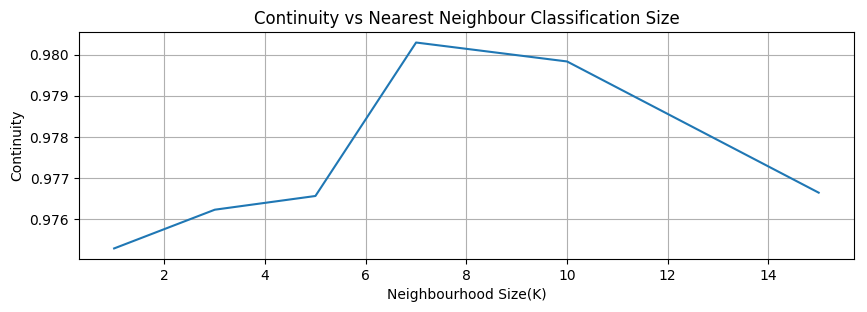

In [63]:
X0= list(m.X.mean[:,0])
X1= list(m.X.mean[:,1])
t= np.column_stack((X0, X1))
dd_proj = distance_matrix(t)
nn_orig = dd_orig.argsort()
nn_proj = dd_proj.argsort()
ranks_proj = rank_matrix(dd_proj)

j=0
cont=[]
for k in ks:
    moved = []
    for i in range(X.shape[0]):
        moved.append(moved_out(nn_orig, nn_proj, i, k))
    cont.append(trustcont_sum(moved, ranks_proj, k))
    print('Neearest neighbourboost size k =' + str(k)+ ' ' + 'Continuity:' + str(cont[j]))
    j+=1
pyplot.figure(figsize=(10,3), dpi=100).set_facecolor('white')
pyplot.plot(ks,cont)
pyplot.grid()
pyplot.xlabel('Neighbourhood Size(K)')
pyplot.ylabel('Continuity')
pyplot.title('Continuity vs Nearest Neighbour Classification Size')

Neearest neighbourboost size k =1 Trust:0.9839989759344598
Neearest neighbourboost size k =3 Trust:0.9824872097599371
Neearest neighbourboost size k =5 Trust:0.9807640570352435
Neearest neighbourboost size k =7 Trust:0.9818396923986986
Neearest neighbourboost size k =10 Trust:0.9862745098039216
Neearest neighbourboost size k =15 Trust:0.9865464632454923


Text(0.5,1,'Trust vs Nearest Neighbour Classification Size')

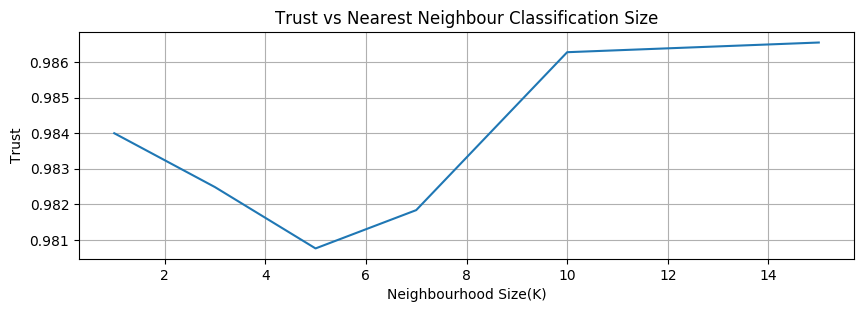

In [65]:
ranks_orig =rank_matrix(dd_orig)
trust = []
j=0
for k in ks:
    moved = []
    for i in range(X_flat.shape[0]):
        moved.append(moved_in(nn_orig, nn_proj, i, k))
    trust.append(trustcont_sum(moved, ranks_orig, k))
    print('Neearest neighbourboost size k =' + str(k)+ ' ' + 'Trust:' + str(trust[j]))
    j+=1
pyplot.figure(figsize=(10,3), dpi=100).set_facecolor('white')
pyplot.plot(ks,trust)
pyplot.grid()
pyplot.xlabel('Neighbourhood Size(K)')
pyplot.ylabel('Trust')
#pyplot.yscale('log')
pyplot.title('Trust vs Nearest Neighbour Classification Size')

In [66]:
kernel = GPy.kern.RBF(5, ARD=True,lengthscale=fracs.detach().numpy()) 
m2 = GPy.models.GPLVM(X_flat, input_dim= 5 ,kernel=kernel)
m2.data_labels = X_flat.argmax(axis=1)
loss3 = m2.optimize('lbfgs', messages=1,max_iters=15000)

Neearest neighbourboost size k =1 Continuity:0.7664490527393754
Neearest neighbourboost size k =3 Continuity:0.7786523241068696
Neearest neighbourboost size k =5 Continuity:0.7613532418617164
Neearest neighbourboost size k =7 Continuity:0.7640540274080647
Neearest neighbourboost size k =10 Continuity:0.7555124613948143
Neearest neighbourboost size k =15 Continuity:0.7437098679817127


Text(0.5,1,'Continuity vs Nearest Neighbour Classification Size')

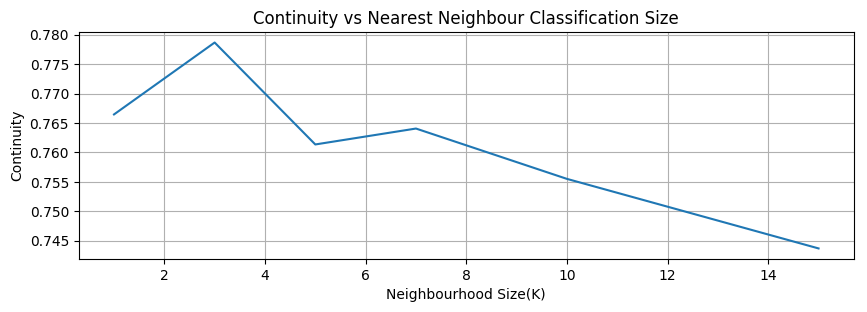

In [67]:
dd_orig = distance_matrix(X_flat)
t = np.array(m2.X)
dd_proj = distance_matrix(t)
nn_orig = dd_orig.argsort()
nn_proj = dd_proj.argsort()
ranks_proj = rank_matrix(dd_proj)

j=0
cont=[]
for k in ks:
    moved = []
    for i in range(X_flat.shape[0]):
        moved.append(moved_out(nn_orig, nn_proj, i, k))
    cont.append(trustcont_sum(moved, ranks_proj, k))
    print('Neearest neighbourboost size k =' + str(k)+ ' ' + 'Continuity:' + str(cont[j]))
    j+=1
pyplot.figure(figsize=(10,3), dpi=100).set_facecolor('white')
pyplot.plot(ks,cont)
pyplot.grid()
pyplot.xlabel('Neighbourhood Size(K)')
pyplot.ylabel('Continuity')
pyplot.title('Continuity vs Nearest Neighbour Classification Size')

Neearest neighbourboost size k =1 Trust:0.9292754736303124
Neearest neighbourboost size k =3 Trust:0.9095937732301369
Neearest neighbourboost size k =5 Trust:0.9000538068334678
Neearest neighbourboost size k =7 Trust:0.8927437641723356
Neearest neighbourboost size k =10 Trust:0.8812540400775695
Neearest neighbourboost size k =15 Trust:0.8626701597575384


Text(0.5,1,'Trust vs Nearest Neighbour Classification Size')

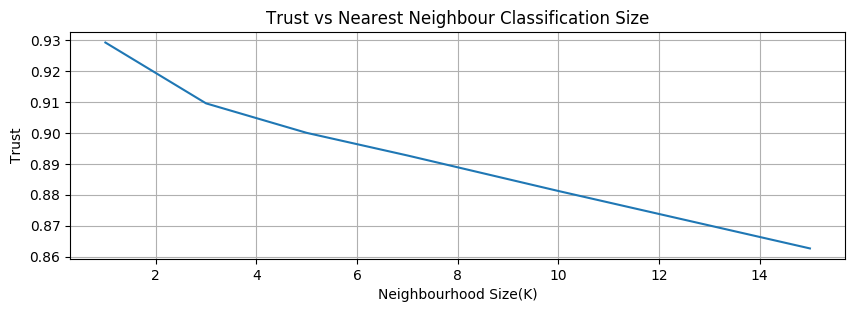

In [68]:
ranks_orig =rank_matrix(dd_orig)
trust = []
j=0
for k in ks:
    moved = []
    for i in range(X_flat.shape[0]):
        moved.append(moved_in(nn_orig, nn_proj, i, k))
    trust.append(trustcont_sum(moved, ranks_orig, k))
    print('Neearest neighbourboost size k =' + str(k)+ ' ' + 'Trust:' + str(trust[j]))
    j+=1
pyplot.figure(figsize=(10,3), dpi=100).set_facecolor('white')
pyplot.plot(ks,trust)
pyplot.grid()
pyplot.xlabel('Neighbourhood Size(K)')
pyplot.ylabel('Trust')
#pyplot.yscale('log')
pyplot.title('Trust vs Nearest Neighbour Classification Size')

In [69]:
from __future__ import print_function
import gpflow
from gpflow import kernels
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
import pods
pods.datasets.overide_manual_authorize = True  # dont ask to authorize
gpflow.settings.numerics.quadrature = 'error'  

In [77]:
Q = 5
M = 20  # number of inducing pts
N = X_flat.shape[0]
X_mean = gpflow.models.PCA_reduce(X_flat, Q) # Initialise via PCA
Z = np.random.permutation(X_mean.copy())[:M]
k = (kernels.RBF(5, ARD=True))
m4 = gpflow.models.BayesianGPLVM(X_mean=X_mean, X_var=0.1*np.ones((N, Q)), Y=X_flat,
                                kern=k, M=M, Z=Z)

In [78]:
m4.likelihood.variance= 0.00390268

In [79]:
m4.compile()
o = gpflow.train.AdamOptimizer(0.01)
#o.minimize(m4, maxiter=15) # start near MAP

In [81]:
s = gpflow.train.HMC()
samples = s.sample(m4, 100, epsilon=0.12, lmax=20, lmin=5, thin=5, logprobs=True)

In [82]:
X_loc = np.average(samples['BayesianGPLVM/X_mean'], axis=0)
X_var = np.average(samples['BayesianGPLVM/X_var'], axis=0)
log_prob = samples.logprobs

Neearest neighbourboost size k =1 Continuity:1.0
Neearest neighbourboost size k =3 Continuity:1.0
Neearest neighbourboost size k =5 Continuity:1.0
Neearest neighbourboost size k =7 Continuity:1.0
Neearest neighbourboost size k =10 Continuity:1.0
Neearest neighbourboost size k =15 Continuity:1.0


Text(0.5,1,'Continuity vs Nearest Neighbour Classification Size')

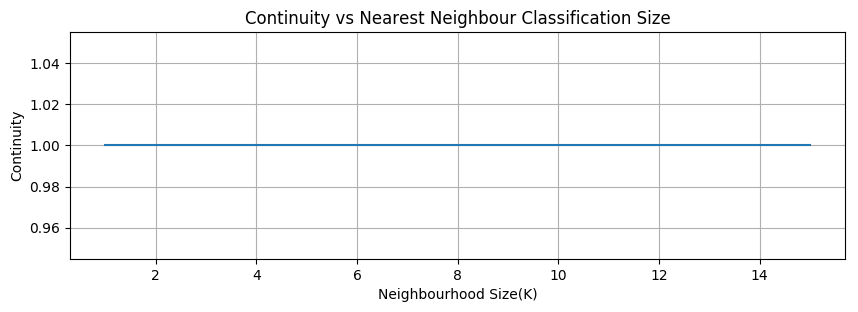

In [84]:
t = np.array(X_loc)
dd_proj = distance_matrix(t)
nn_orig = dd_orig.argsort()
nn_proj = dd_proj.argsort()
ranks_proj = rank_matrix(dd_proj)

j=0
cont=[]
for k in ks:
    moved = []
    for i in range(X_flat.shape[0]):
        moved.append(moved_out(nn_orig, nn_proj, i, k))
    cont.append(trustcont_sum(moved, ranks_proj, k))
    print('Neearest neighbourboost size k =' + str(k)+ ' ' + 'Continuity:' + str(cont[j]))
    j+=1
pyplot.figure(figsize=(10,3), dpi=100).set_facecolor('white')
pyplot.plot(ks,cont)
pyplot.grid()
pyplot.xlabel('Neighbourhood Size(K)')
pyplot.ylabel('Continuity')
pyplot.title('Continuity vs Nearest Neighbour Classification Size')

Neearest neighbourboost size k =1 Trust:1.0
Neearest neighbourboost size k =3 Trust:1.0
Neearest neighbourboost size k =5 Trust:1.0
Neearest neighbourboost size k =7 Trust:1.0
Neearest neighbourboost size k =10 Trust:1.0
Neearest neighbourboost size k =15 Trust:1.0


Text(0.5,1,'Trust vs Nearest Neighbour Classification Size')

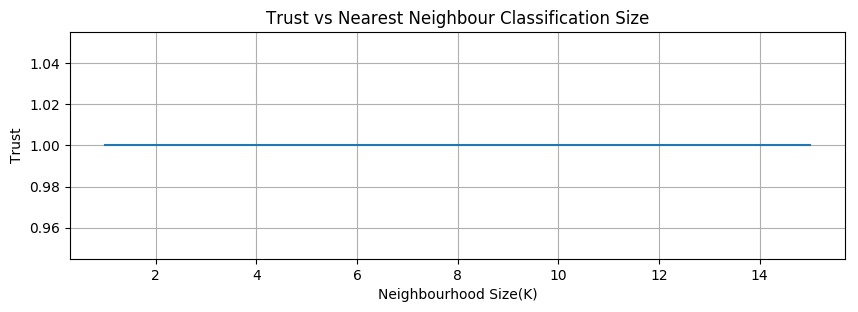

In [86]:
ranks_orig =rank_matrix(dd_orig)
trust = []
j=0
for k in ks:
    moved = []
    for i in range(X_flat.shape[0]):
        moved.append(moved_in(nn_orig, nn_proj, i, k))
    trust.append(trustcont_sum(moved, ranks_orig, k))
    print('Neearest neighbourboost size k =' + str(k)+ ' ' + 'Trust:' + str(trust[j]))
    j+=1
pyplot.figure(figsize=(10,3), dpi=100).set_facecolor('white')
pyplot.plot(ks,trust)
pyplot.grid()
pyplot.xlabel('Neighbourhood Size(K)')
pyplot.ylabel('Trust')
pyplot.title('Trust vs Nearest Neighbour Classification Size')

In [93]:
X.shape

(126, 309)

In [87]:
from sklearn.decomposition import PCA

In [94]:
pca_dims = PCA()
pca_dims.fit(X)
cumsum = np.cumsum(pca_dims.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

Text(0.5,1,'PCA Explained Variance Ratio')

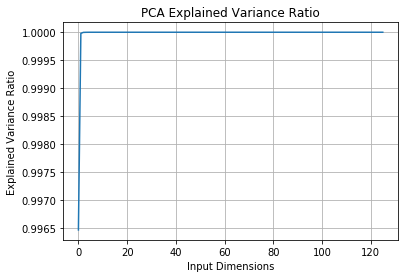

In [95]:
plt.figure()
plt.plot(list(range(len(pca_dims.explained_variance_ratio_))),cumsum)
plt.grid()
plt.xlabel('Input Dimensions')
plt.ylabel('Explained Variance Ratio')
plt.title('PCA Explained Variance Ratio')

In [97]:
pca = PCA(n_components=d)
X_reduced = pca.fit_transform(X)
X_recovered = pca.inverse_transform(X_reduced)

Neearest neighbourboost size k =1 Continuity:0.9950716845878136
Neearest neighbourboost size k =3 Continuity:0.9961957234684508
Neearest neighbourboost size k =5 Continuity:0.9973903685768093
Neearest neighbourboost size k =7 Continuity:0.9980577738341714
Neearest neighbourboost size k =10 Continuity:0.998728722258134


Text(0.5,1,'Continuity vs Nearest Neighbour Classification Size')

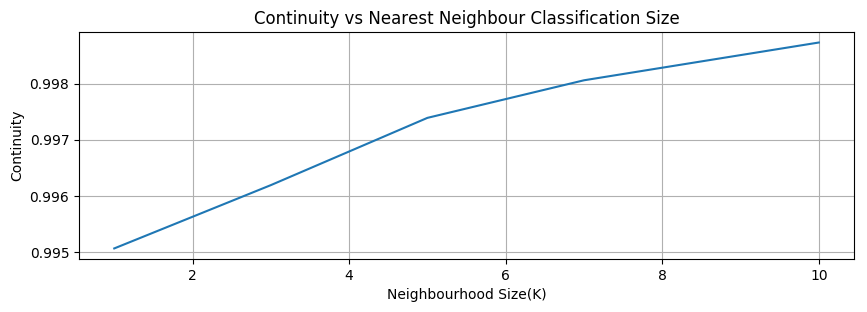

In [99]:
dd_orig = distance_matrix(X)
dd_proj = distance_matrix(X_reduced)
nn_orig = dd_orig.argsort()
nn_proj = dd_proj.argsort()
ranks_proj = rank_matrix(dd_proj)

ks=[1,3,5,7,10] #15,20,25,30,40,45,50,55,60,75]
j=0
cont=[]
for k in ks:
    moved = []
    for i in range(X.shape[0]):
        moved.append(moved_out(nn_orig, nn_proj, i, k))
    cont.append(trustcont_sum(moved, ranks_proj, k))
    print('Neearest neighbourboost size k =' + str(k)+ ' ' + 'Continuity:' + str(cont[j]))
    j+=1
pyplot.figure(figsize=(10,3), dpi=100).set_facecolor('white')
pyplot.plot(ks,cont)
pyplot.grid()
pyplot.xlabel('Neighbourhood Size(K)')
pyplot.ylabel('Continuity')
pyplot.title('Continuity vs Nearest Neighbour Classification Size')

Neearest neighbourboost size k =1 Trust:0.9825908858166923
Neearest neighbourboost size k =3 Trust:0.987756351392715
Neearest neighbourboost size k =5 Trust:0.9894673123486682
Neearest neighbourboost size k =7 Trust:0.9901804199940846
Neearest neighbourboost size k =10 Trust:0.9909143144437262


Text(0.5,1,'Trust vs Nearest Neighbour Classification Size')

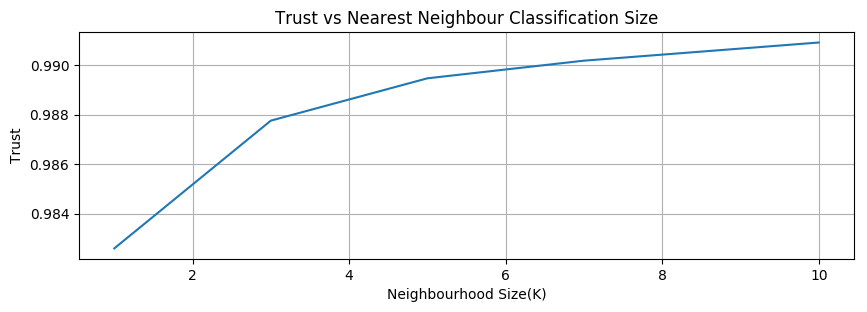

In [101]:
ranks_orig =rank_matrix(dd_orig)
trust = []
j=0
for k in ks:
    moved = []
    for i in range(X_flat.shape[0]):
        moved.append(moved_in(nn_orig, nn_proj, i, k))
    trust.append(trustcont_sum(moved, ranks_orig, k))
    print('Neearest neighbourboost size k =' + str(k)+ ' ' + 'Trust:' + str(trust[j]))
    j+=1
pyplot.figure(figsize=(10,3), dpi=100).set_facecolor('white')
pyplot.plot(ks,trust)
pyplot.grid()
pyplot.xlabel('Neighbourhood Size(K)')
pyplot.ylabel('Trust')
#pyplot.yscale('log')
pyplot.title('Trust vs Nearest Neighbour Classification Size')

In [103]:
from time import time

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter

from sklearn import manifold, datasets

In [102]:
n_neighbors = 10
n_components = 5

In [104]:
methods = ['standard']
labels = ['LLE']

for i, method in enumerate(methods):
    t0 = time()
    LLC_obtain = manifold.LocallyLinearEmbedding(n_neighbors, n_components,
                                        eigen_solver='auto',
                                        method=method).fit_transform(X_flat)
    t1 = time()
    print("%s: %.2g sec" % (methods[i], t1 - t0))

standard: 0.32 sec


In [106]:
dd_orig = distance_matrix(X_flat)
dd_proj = distance_matrix(LLC_obtain)
nn_orig = dd_orig.argsort()
nn_proj = dd_proj.argsort()
ranks_proj = rank_matrix(dd_proj)
ks=[1,3,5,7,10]
j=0
cont=[]
for k in ks:
    moved = []
    for i in range(X.shape[0]):
        moved.append(moved_out(nn_orig, nn_proj, i, k))
    cont.append(trustcont_sum(moved, ranks_proj, k))
    print('Neearest neighbourboost size k =' + str(k)+ ' ' + 'Continuity:' + str(cont[j]))
    j+=1

Neearest neighbourboost size k =1 Continuity:0.9660778289810548
Neearest neighbourboost size k =3 Continuity:0.9446849446849447
Neearest neighbourboost size k =5 Continuity:0.9336830777508743
Neearest neighbourboost size k =7 Continuity:0.928443261362516
Neearest neighbourboost size k =10 Continuity:0.9139696904402786


Neearest neighbourboost size k =1 Trust:0.9780465949820789
Neearest neighbourboost size k =3 Trust:0.978704796886615
Neearest neighbourboost size k =5 Trust:0.9793247242399785
Neearest neighbourboost size k =7 Trust:0.9800256334417825
Neearest neighbourboost size k =10 Trust:0.9767363355598649


Text(0.5,1,'Trust vs Nearest Neighbour Classification Size')

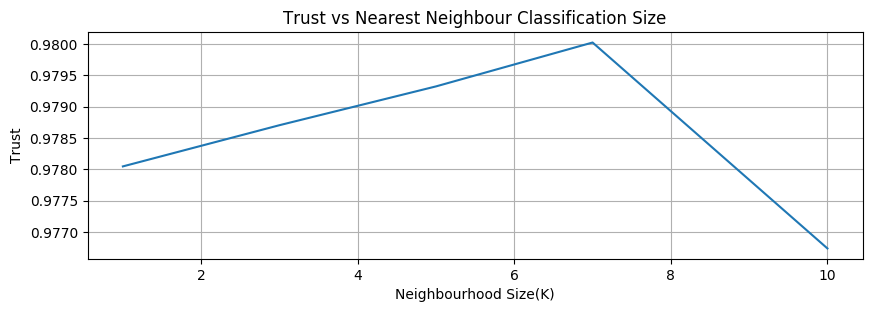

In [108]:
ranks_orig =rank_matrix(dd_orig)
trust = []
j=0
for k in ks:
    moved = []
    for i in range(X.shape[0]):
        moved.append(moved_in(nn_orig, nn_proj, i, k))
    trust.append(trustcont_sum(moved, ranks_orig, k))
    print('Neearest neighbourboost size k =' + str(k)+ ' ' + 'Trust:' + str(trust[j]))
    j+=1
pyplot.figure(figsize=(10,3), dpi=100).set_facecolor('white')
pyplot.plot(ks,trust)
pyplot.grid()
pyplot.xlabel('Neighbourhood Size(K)')
pyplot.ylabel('Trust')
#pyplot.yscale('log')
pyplot.title('Trust vs Nearest Neighbour Classification Size')

In [109]:
t0 = time()
mds = manifold.MDS(n_components, max_iter=100, n_init=1)
mds_reduce = mds.fit_transform(X_flat)
t1 = time()
print("MDS: %.2g sec" % (t1 - t0))

MDS: 0.079 sec


In [112]:
dd_orig = distance_matrix(X_flat)
dd_proj = distance_matrix(mds_reduce)
nn_orig = dd_orig.argsort()
nn_proj = dd_proj.argsort()
ranks_proj = rank_matrix(dd_proj)
ks=[1,3,5,7,10]
j=0
cont=[]
for k in ks:
    moved = []
    for i in range(X.shape[0]):
        moved.append(moved_out(nn_orig, nn_proj, i, k))
    cont.append(trustcont_sum(moved, ranks_proj, k))
    print('Neearest neighbourboost size k =' + str(k)+ ' ' + 'Continuity:' + str(cont[j]))
    j+=1

Neearest neighbourboost size k =1 Continuity:0.9992959549411162
Neearest neighbourboost size k =3 Continuity:0.9996939087848179
Neearest neighbourboost size k =5 Continuity:0.9997847726661286
Neearest neighbourboost size k =7 Continuity:0.9997732426303855
Neearest neighbourboost size k =10 Continuity:0.9998276233570351


Neearest neighbourboost size k =1 Trust:0.9995519713261649
Neearest neighbourboost size k =3 Trust:0.9997157724430452
Neearest neighbourboost size k =5 Trust:0.9998251277912295
Neearest neighbourboost size k =7 Trust:0.9999309868875086
Neearest neighbourboost size k =10 Trust:0.9999281763987646


Text(0.5,1,'Trust vs Nearest Neighbour Classification Size')

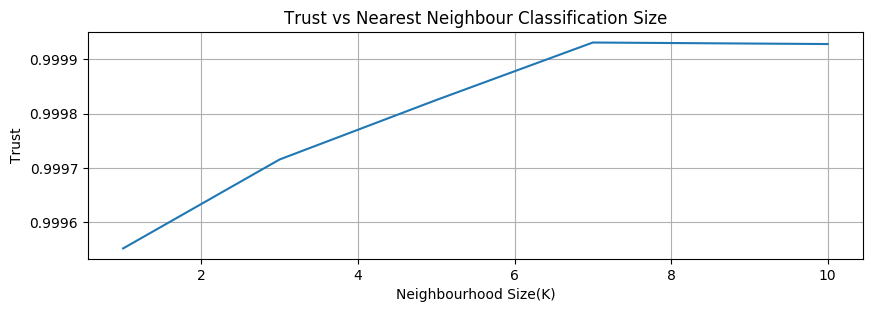

In [113]:
ranks_orig =rank_matrix(dd_orig)
trust = []
j=0
for k in ks:
    moved = []
    for i in range(X.shape[0]):
        moved.append(moved_in(nn_orig, nn_proj, i, k))
    trust.append(trustcont_sum(moved, ranks_orig, k))
    print('Neearest neighbourboost size k =' + str(k)+ ' ' + 'Trust:' + str(trust[j]))
    j+=1
pyplot.figure(figsize=(10,3), dpi=100).set_facecolor('white')
pyplot.plot(ks,trust)
pyplot.grid()
pyplot.xlabel('Neighbourhood Size(K)')
pyplot.ylabel('Trust')
#pyplot.yscale('log')
pyplot.title('Trust vs Nearest Neighbour Classification Size')

In [114]:
t0 = time()
se = manifold.SpectralEmbedding(n_components=n_components,
                                n_neighbors=n_neighbors)
Spectral_reduce = se.fit_transform(X_flat)
t1 = time()
print("SpectralEmbedding: %.2g sec" % (t1 - t0))

SpectralEmbedding: 0.13 sec


In [115]:
dd_orig = distance_matrix(X_flat)
dd_proj = distance_matrix(Spectral_reduce)
nn_orig = dd_orig.argsort()
nn_proj = dd_proj.argsort()
ranks_proj = rank_matrix(dd_proj)
ks=[1,3,5,7,10]
j=0
cont=[]
for k in ks:
    moved = []
    for i in range(X.shape[0]):
        moved.append(moved_out(nn_orig, nn_proj, i, k))
    cont.append(trustcont_sum(moved, ranks_proj, k))
    print('Neearest neighbourboost size k =' + str(k)+ ' ' + 'Continuity:' + str(cont[j]))
    j+=1

Neearest neighbourboost size k =1 Continuity:0.9887992831541219
Neearest neighbourboost size k =3 Continuity:0.9882154882154882
Neearest neighbourboost size k =5 Continuity:0.9886467581382835
Neearest neighbourboost size k =7 Continuity:0.9894311347727497
Neearest neighbourboost size k =10 Continuity:0.9913021618903972


Neearest neighbourboost size k =1 Trust:0.9831029185867896
Neearest neighbourboost size k =3 Trust:0.98270584634221
Neearest neighbourboost size k =5 Trust:0.9788270110304008
Neearest neighbourboost size k =7 Trust:0.9786157941437444
Neearest neighbourboost size k =10 Trust:0.9813474107591754


Text(0.5,1,'Trust vs Nearest Neighbour Classification Size')

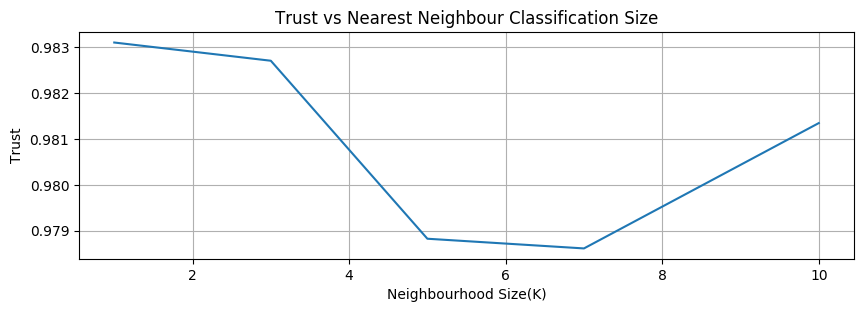

In [116]:
ranks_orig =rank_matrix(dd_orig)
trust = []
j=0
for k in ks:
    moved = []
    for i in range(X.shape[0]):
        moved.append(moved_in(nn_orig, nn_proj, i, k))
    trust.append(trustcont_sum(moved, ranks_orig, k))
    print('Neearest neighbourboost size k =' + str(k)+ ' ' + 'Trust:' + str(trust[j]))
    j+=1
pyplot.figure(figsize=(10,3), dpi=100).set_facecolor('white')
pyplot.plot(ks,trust)
pyplot.grid()
pyplot.xlabel('Neighbourhood Size(K)')
pyplot.ylabel('Trust')
#pyplot.yscale('log')
pyplot.title('Trust vs Nearest Neighbour Classification Size')

In [118]:
n_components=2
t0 = time()
tsne = manifold.TSNE(n_components=n_components, init='pca', random_state=0)
tsne_red = tsne.fit_transform(X_flat)
t1 = time()
print("t-SNE: %.2g sec" % (t1 - t0))

t-SNE: 3.4 sec


In [120]:
dd_orig = distance_matrix(X_flat)
dd_proj = distance_matrix(tsne_red)
nn_orig = dd_orig.argsort()
nn_proj = dd_proj.argsort()
ranks_proj = rank_matrix(dd_proj)
ks=[1,3,5,7,10]
j=0
cont=[]
for k in ks:
    moved = []
    for i in range(X.shape[0]):
        moved.append(moved_out(nn_orig, nn_proj, i, k))
    cont.append(trustcont_sum(moved, ranks_proj, k))
    print('Neearest neighbourboost size k =' + str(k)+ ' ' + 'Continuity:' + str(cont[j]))
    j+=1

Neearest neighbourboost size k =1 Continuity:0.9944956477214542
Neearest neighbourboost size k =3 Continuity:0.994577812759631
Neearest neighbourboost size k =5 Continuity:0.9966505246166263
Neearest neighbourboost size k =7 Continuity:0.9976239771270827
Neearest neighbourboost size k =10 Continuity:0.9982403217697335


Neearest neighbourboost size k =1 Trust:0.996031746031746
Neearest neighbourboost size k =3 Trust:0.9953649044558135
Neearest neighbourboost size k =5 Trust:0.9959375840731773
Neearest neighbourboost size k =7 Trust:0.9969042689539585
Neearest neighbourboost size k =10 Trust:0.9981038569273863


Text(0.5,1,'Trust vs Nearest Neighbour Classification Size')

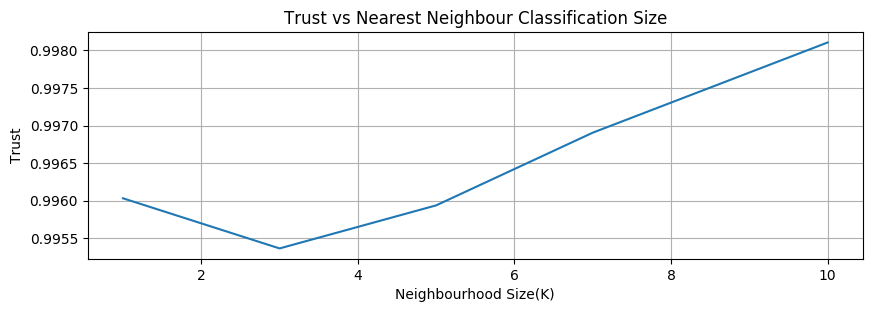

In [121]:
ranks_orig =rank_matrix(dd_orig)
trust = []
j=0
for k in ks:
    moved = []
    for i in range(X.shape[0]):
        moved.append(moved_in(nn_orig, nn_proj, i, k))
    trust.append(trustcont_sum(moved, ranks_orig, k))
    print('Neearest neighbourboost size k =' + str(k)+ ' ' + 'Trust:' + str(trust[j]))
    j+=1
pyplot.figure(figsize=(10,3), dpi=100).set_facecolor('white')
pyplot.plot(ks,trust)
pyplot.grid()
pyplot.xlabel('Neighbourhood Size(K)')
pyplot.ylabel('Trust')
#pyplot.yscale('log')
pyplot.title('Trust vs Nearest Neighbour Classification Size')

In [123]:
X.shape

(126, 309)

In [11]:
def d_euclidean(a,b):
    """Returns euclidean distance between vectors a and b"""

    return math.sqrt(sum([ (x - y)**2 for (x,y) in zip (a,b) ]))
def rank_matrix(x):
    """Returns rank matrix from pairwise distance matrix a"""
    
    m = x.argsort()
    r = numpy.zeros(x.shape)

    vectors = x.shape[0]

    for i in range(vectors):
        for j in range(vectors):
            pos = numpy.where(m[i,:]==j)
            r[i,j] = pos[0][0] # there should be a better syntax for this
        
    return r.astype('int')


def centering(x):
    """Center matrix x to origo"""
    return x - x.mean(axis=0)


def double_centering(x):
    """Double center matrix x"""
    pass

def distance_matrix(x, distf=None):
    """Returns distance matrix of pairwise distances between vectors
    stored in array a

    distf is function used to calculate distance between vectors,
    if None, euclidean distance is used
    """

    if distf == None:
        distf = d_euclidean

    vectors = x.shape[0]
    d = numpy.zeros([vectors, vectors])

    for i in range(vectors):
        for j in range(i,vectors):
            dd = distf(x[i,:], x[j,:])
            d[i,j] = dd
            d[j,i] = dd

    return d
def moved_out(nn_orig, nn_proj, i, k):
    """Determine points that were neighbours in the original space,
    but are not neighbours in the projection space.

    nn_orig
      neighbourhood matrix for original data

    nn_proj
      neighbourhood matrix for projection data

    i
      index of the point considered

    k
      size of the neighbourhood considered

    Return a list of indices for 'moved out' values 
    """

    oo = list(nn_orig[i, 1:k+1])
    pp = list(nn_proj[i, 1:k+1])

    for j in pp:
        if (j in pp) and (j in oo):
            oo.remove(j)

    return oo
def moved_in(nn_orig, nn_proj, i, k):
    """Determine points that are neighbours in the projection space,
    but were not neighbours in the original space.

    nn_orig
      neighbourhood matrix for original data

    nn_proj
      neighbourhood matrix for projection data

    i
      index of the point considered

    k
      size of the neighbourhood considered

    Return a list of indices for points which are 'moved in' to point i
    """

    pp = list(nn_proj[i, 1:k+1])
    oo = list(nn_orig[i, 1:k+1])

    for j in oo:
        if (j in oo) and (j in pp):
            pp.remove(j)

    return pp


def scaling_term(k, n):
    """Term that scales measure between zero and one

    k  size of the neighbourhood
    n  number of datapoints
    """

    if k < (n / 2.0):
        return 2.0 / ((n*k)*(2*n - 3*k - 1))
    else:
        return 2.0 / (n * (n - k) * (n - k - 1))


def trustcont_sum(moved, ranks, k):
    """Calculate sum used in trustworthiness or continuity calculation.

    moved

       List of lists of indices for those datapoints that have either
       moved away in (Continuity) or moved in (Trustworthiness)
       projection

    ranks

       Rank matrix of data set. For trustworthiness, ranking is in the
       original space, for continuity, ranking is in the projected
       space.

    k
       size of the neighbournood
    """

    n = ranks.shape[0]
    s = 0

    # todo: weavefy this for speed
    for i in range(n):
        for j in moved[i]:
            s = s + (ranks[i, j] - k)

    a = scaling_term(k, n)

    return 1 - a * s